<a href="https://colab.research.google.com/github/raunaksatone5/Retail-Customer-Segmentation/blob/main/retailcustomersegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **Project Title : Online Retail Customer Segmentation**

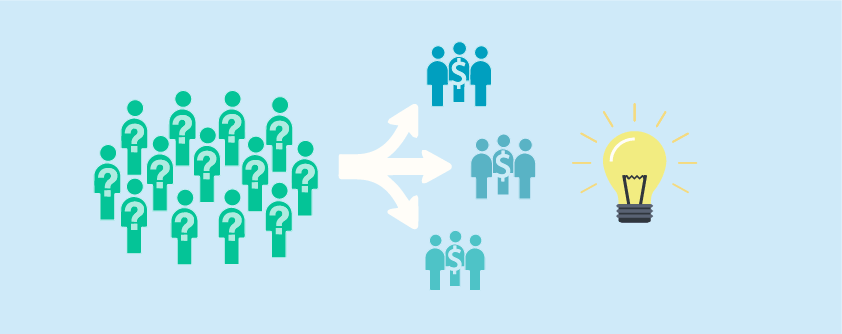

## **Problem Description**

### In this project, your task is to identify major customer segments on a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## <b> Data Description </b>

### <b>Attribute Information: </b>

* ### InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* ### StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* ### Description: Product (item) name. Nominal.
* ### Quantity: The quantities of each product (item) per transaction. Numeric.
* ### InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* ### UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* ### CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* ### Country: Country name. Nominal, the name of the country where each customer resides.

In [1]:
# importing all the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import math

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# loading dataset
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/book recommender/Copy of Online Retail.xlsx")

In [3]:
# first look at our data
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Let's have a look at last five rows of our dataset to have a lookover
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [5]:
# Check shape of data
df.shape

(541909, 8)

In [6]:
# feature info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
# Descriptive statistics summary
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


The max value for Quantity is 80995, this could represent cancelled or returned orders.

The UnitPrice also have few negative values which is uncommon,these transactions could represent cancelled orders by customers or bad-debt incurred by the business.

Bad debt adjustments will be dropped from the dataset as these do not represent actual sales.

We need to clean the above values by removing from the dataset.

In [8]:
# Getting the list of all the features
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

## **Data Pre-processing**
1. Treating the missing values

In [9]:
# checking for null values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Text(0.5, 1.0, 'Percentage of missing values per columns')

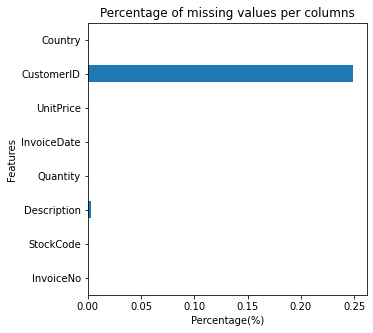

In [10]:
# Plot to show the percentage of missing values n the data set
plt.figure(figsize=(5, 5))

df.isnull().mean(axis=0).plot.barh()

plt.xlabel("Percentage(%)")
plt.ylabel("Features")
plt.title("Percentage of missing values per columns")

There are almost 25% missing CustomerID. We need to remove them as there is no way we can get the number of CustomerID.

In [11]:
# taking only non-null CustomerId
df = df[pd.notnull(df['CustomerID'])]

In [12]:
# Check for the shape of the dataset after droppinng the null values:
df.shape

(406829, 8)

2. Checking for the Duplicate values:


In [13]:
# Checking for duplicates in our dataset
if df.duplicated().any():
    print("Duplicate Rows in our dataset are: {}".format(df.duplicated().sum()))
else:
    print("There are no duplicate records present in our dataset")

Duplicate Rows in our dataset are: 5225


Invoice number cannot be same for different orders and since all the items are unique we will have to drop the duplicate values.

In [14]:
# Drop the duplicated values
df.drop_duplicates(inplace=True)
print("Shape of the data set after dropping the duplicates is :\n{}".format(df.shape))


Shape of the data set after dropping the duplicates is :
(401604, 8)


## **Exploratory Data Analysis**

In [15]:
#Let's have a look at number of unique values in each feature 
features=df.columns
features

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [16]:
#Let's have a look at the unique values in each column
for feature in features:
    print(feature,':')
    print(df[feature].nunique())
    print("-----------------")

InvoiceNo :
22190
-----------------
StockCode :
3684
-----------------
Description :
3896
-----------------
Quantity :
436
-----------------
InvoiceDate :
20460
-----------------
UnitPrice :
620
-----------------
CustomerID :
4372
-----------------
Country :
37
-----------------


In [17]:
# Countrywise customer count percentage
df.Country.value_counts(normalize=True)

United Kingdom          0.888258
Germany                 0.023605
France                  0.021103
EIRE                    0.018613
Spain                   0.006295
Netherlands             0.005904
Belgium                 0.005152
Switzerland             0.004674
Portugal                0.003663
Australia               0.003132
Norway                  0.002704
Italy                   0.001999
Channel Islands         0.001885
Finland                 0.001731
Cyprus                  0.001521
Sweden                  0.001148
Austria                 0.000998
Denmark                 0.000969
Japan                   0.000891
Poland                  0.000849
USA                     0.000725
Israel                  0.000615
Unspecified             0.000600
Singapore               0.000570
Iceland                 0.000453
Canada                  0.000376
Greece                  0.000364
Malta                   0.000316
United Arab Emirates    0.000169
European Community      0.000152
RSA       

1. Top 10 ordering Countries

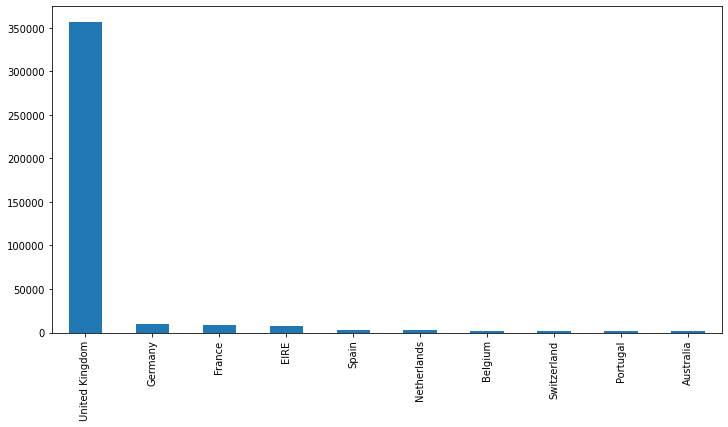

In [18]:
# top 10 ordering countries
df.Country.value_counts().head(10).plot.bar(figsize=(12,6))

**Cancelled Items**

From the description,If this code starts with letter 'C', it indicates a cancellation.

In [19]:
# Transactions with Cancelled Items.
cancelled = df[df.InvoiceNo.str.contains('C',na=False)]
cancelled.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [20]:
# Creating the dataframe for cancelled orders
cancelled_orders=cancelled[['InvoiceNo','Country']].groupby('Country').count().sort_values(by='InvoiceNo', ascending=False).head(10).reset_index()


2. No. Of Cancelled Orders 

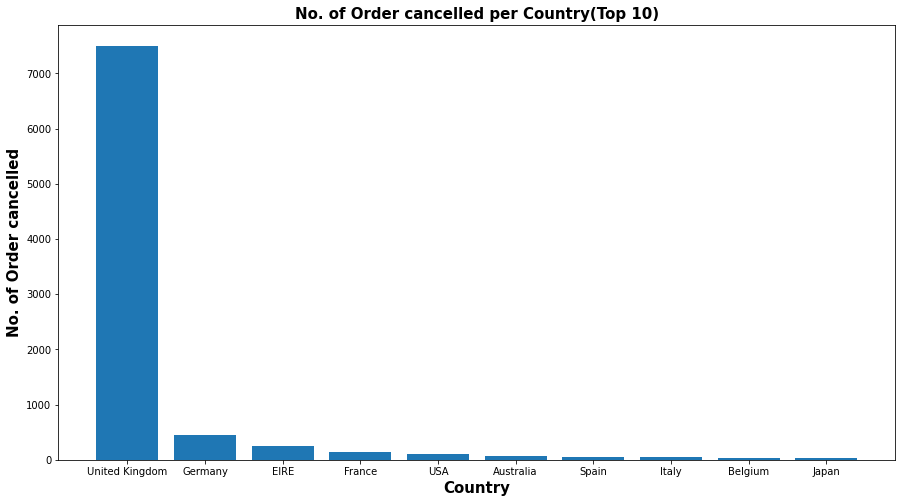

In [21]:
# Learning through visualization
# Figure Size
plt.figure(figsize=(15,8))

## Define x and y axis
x=cancelled_orders['Country']
y=cancelled_orders['InvoiceNo']

# creating the bar plot
plt.bar(x,y)

# set xlabel. ylabel and title
plt.xlabel("Country", size=15, weight='bold')
plt.ylabel("No. of Order cancelled", size=15, weight='bold')
plt.title("No. of Order cancelled per Country(Top 10)",size=15, weight='bold')

## Showing the plot
plt.show()

* United Kingdom has got the maximum number cancelled orders followed by Germany with considerable margin.

* Australia,Spain,Italy,Belgium,Japan has least and almost negligible amount of cancelled orders.

In [22]:
# Taking only invoices which were not cancelled
df = df[~df["InvoiceNo"].str.contains("C", na=False)]

In [23]:
# Taking only postive values from variables
df = df[df['Quantity']>0]
df = df[df['UnitPrice']>0]
df.shape

(392692, 8)

* We can see that there is maximum proportion (up to 90% of customers) of 'United Kingdom' customers. So we will take 'United Kingdom' customer for our analysis.

In [24]:
# taking only united kingdom related customers
df = df[df.Country == 'United Kingdom']

In [25]:
# lets check the  info once  again
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349203 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    349203 non-null  object        
 1   StockCode    349203 non-null  object        
 2   Description  349203 non-null  object        
 3   Quantity     349203 non-null  int64         
 4   InvoiceDate  349203 non-null  datetime64[ns]
 5   UnitPrice    349203 non-null  float64       
 6   CustomerID   349203 non-null  float64       
 7   Country      349203 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.0+ MB


In [26]:
# InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceYearMonth'] = df['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df['Date'] = df['InvoiceDate'].dt.strftime('%Y-%m')

3. How many product were sold every month?

In [27]:
# Aggregating the Orders by Month
df_agg = df.groupby("Date").Quantity.sum()
df_agg

Date
2010-12    266573
2011-01    277650
2011-02    212792
2011-03    275385
2011-04    259592
2011-05    301113
2011-06    280321
2011-07    301552
2011-08    310101
2011-09    453420
2011-10    474668
2011-11    568167
2011-12    259971
Name: Quantity, dtype: int64

In [28]:
# converting series to dataframe and resetting index.
df_agg = pd.DataFrame(df_agg)
df_agg = df_agg.reset_index()
df_agg.head()

,Date,Quantity
0,2010-12,266573
1,2011-01,277650
2,2011-02,212792
3,2011-03,275385
4,2011-04,259592


[Text(0, 0.5, 'Quantity'), Text(0.5, 0, 'Date'), Text(0.5, 1.0, 'Orders')]

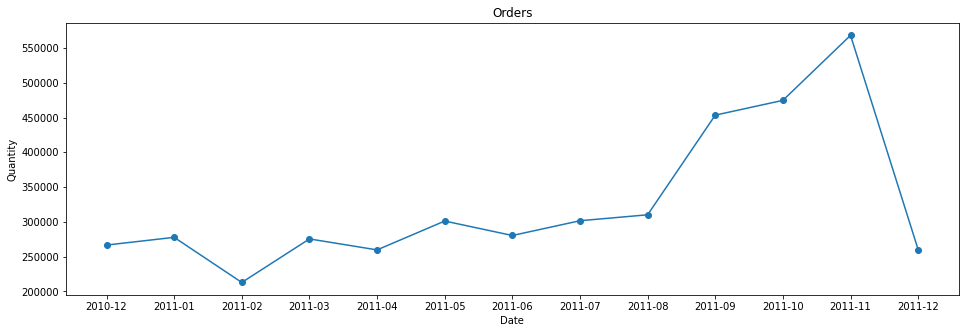

In [29]:
# visualising quantity of orders per month
plt.figure(figsize=(16,5))
plt.plot('Date','Quantity',data=df_agg,marker='o')
plt.gca().set(title='Orders', xlabel='Date', ylabel='Quantity')

4. How much money does customer spend every month?



In [30]:
# Calculating Revenue
# Revenue = Order Count * Average Revenue per Order
df['Revenue'] = df['Quantity']*df['UnitPrice']

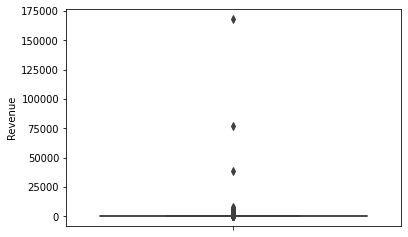

In [31]:
# boxplot on revenue
sns.boxplot(y=df['Revenue'])

In [32]:
# Monthly Revenue
df_revenue = df.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()
df_revenue.head()

,InvoiceYearMonth,Revenue
0,201012,496477.340
1,201101,440876.330
2,201102,354618.200
3,201103,465784.190
4,201104,408733.111


5. Monthly Revenue 

Text(0.5, 1.0, 'Monthly Revenue')

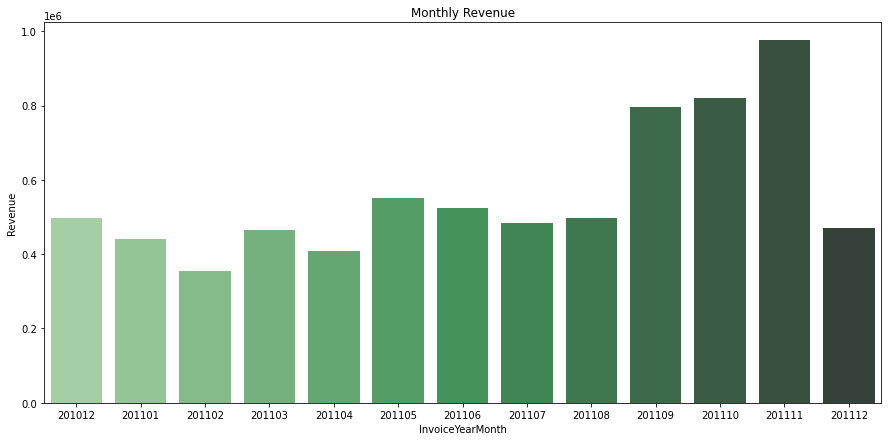

In [33]:
# Visualising monthly revenue with bar plot
plt.figure(figsize=(15,7))
sns.barplot(x=df_revenue['InvoiceYearMonth'],y=df_revenue['Revenue'], palette = "Greens_d")
plt.title('Monthly Revenue')

6. Top 20 Products Sold From the Store


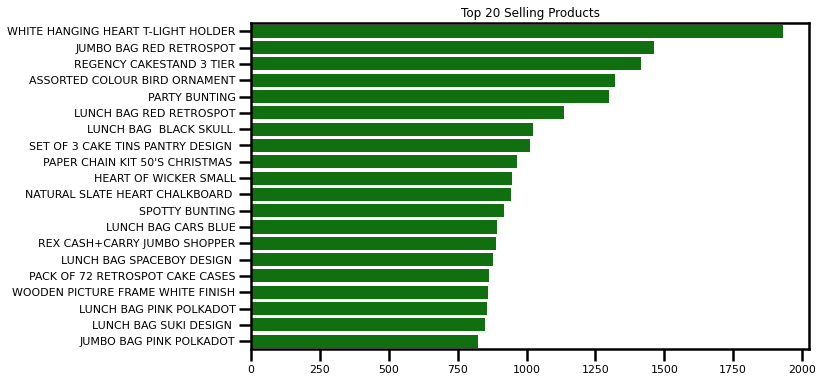

In [34]:
# Creating the required Dataframe
top_products = df['Description'].value_counts()[:20]
plt.figure(figsize=(10,6))

# visualising
sns.set_context("poster",font_scale=0.5)
sns.barplot(y=top_products.index,x=top_products.values,color='green')
plt.title('Top 20 Selling Products')
plt.show()

### **RFM Analysis**

Recency Frequency Monetary (RFM)

RFM analysis allows you to segment customers by the frequency and value of purchases and identify those customers who spend the most money.


Recency — how long it’s been since a customer bought something from us.


Frequency — how often a customer buys from us.

Monetary value — the total value of purchases a customer has made.

The last invoice date is 2011–12–09, we will use this date to calculate Recency.

In [35]:
import datetime as dt
NOW = dt.date(2011,12,9) 
df['Date'] = pd.DatetimeIndex(df.InvoiceDate).date

In [36]:
# Recency data
df_recency = df.groupby(['CustomerID'],as_index=False)['Date'].max()
df_recency.columns = ['CustomerID','Last_Purchase_Date']

df_recency['Recency'] = df_recency.Last_Purchase_Date.apply(lambda x:(NOW - x).days)
df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)
df_recency.head()

,CustomerID,Recency
0,12346.0,325
1,12747.0,2
2,12748.0,0
3,12749.0,3
4,12820.0,3


In [37]:
# Frequency - Monetary
FM_Table = df.groupby('CustomerID').agg({'InvoiceNo'   : lambda x:len(x),
                                         'Revenue'  : lambda x:x.sum()})
FM_Table.rename(columns = {'InvoiceNo' :'Frequency',
                           'Revenue':'Monetary'},inplace= True)
FM_Table.head()

,Frequency,Monetary
CustomerID,,
12346.0,1,77183.60
12747.0,103,4196.01
12748.0,4412,33053.19
12749.0,199,4090.88
12820.0,59,942.34


In [38]:
# Recency Frequency Monetary table
RFM = df_recency.merge(FM_Table,left_on='CustomerID',right_on='CustomerID')
RFM.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,103,4196.01
2,12748.0,0,4412,33053.19
3,12749.0,3,199,4090.88
4,12820.0,3,59,942.34


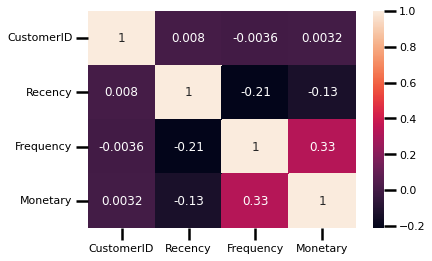

In [39]:
# correlation using heatmap
sns.heatmap(RFM.corr(), annot=True);

**Modeling Data: RFM Quantiles**

Now we split the metrics into segments using quantiles.

We will assign a score from 1 to 4 to each Recency, Frequency and Monetary respectively.

1 is the highest value, and 4 is the lowest value.

A final RFM score (Overall Value) is calculated simply by combining individual RFM score numbers.

In [40]:
# Quantile range
quantiles = RFM.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()

In [41]:
# making copy of rfm table for further process
segmented_rfm = RFM.copy()

In [42]:
# defining function for calculating rscore and FMscore
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [43]:
# quartile ranges
segmented_rfm['R_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles))
segmented_rfm['F_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles))
segmented_rfm['M_quartile'] = segmented_rfm['Monetary'].apply(FMScore, args=('Monetary',quantiles))
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile
0,12346.0,325,1,77183.60,4,4,1
1,12747.0,2,103,4196.01,1,1,1
2,12748.0,0,4412,33053.19,1,1,1
3,12749.0,3,199,4090.88,1,1,1
4,12820.0,3,59,942.34,1,2,2


***Calculating the total RFM score combined.***

RFM_Score = R_quartile + F_quartile + M_quartile 

In [44]:
# calculating rfm score combined
segmented_rfm['RFM_Segment'] = segmented_rfm.R_quartile.map(str)+segmented_rfm.F_quartile.map(str)+segmented_rfm.M_quartile.map(str)


In [45]:
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment
0,12346.0,325,1,77183.60,4,4,1,441
1,12747.0,2,103,4196.01,1,1,1,111
2,12748.0,0,4412,33053.19,1,1,1,111
3,12749.0,3,199,4090.88,1,1,1,111
4,12820.0,3,59,942.34,1,2,2,122


In [46]:
# adding RFM_Score to segmented_rfm
segmented_rfm['RFM_Score'] = segmented_rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)


In [47]:
segmented_rfm.head(10)

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
0,12346.0,325,1,77183.60,4,4,1,441,9
1,12747.0,2,103,4196.01,1,1,1,111,3
2,12748.0,0,4412,33053.19,1,1,1,111,3
3,12749.0,3,199,4090.88,1,1,1,111,3
4,12820.0,3,59,942.34,1,2,2,122,5
5,12821.0,214,6,92.72,4,4,4,444,12
6,12822.0,70,46,948.88,3,2,2,322,7
7,12823.0,74,5,1759.50,3,4,1,341,8
8,12824.0,59,25,397.12,3,3,3,333,9
9,12826.0,2,91,1474.72,1,2,2,122,5


In [48]:
# setting labels for customers
print("Best Customers: ",len(segmented_rfm[segmented_rfm['RFM_Segment']=='111']))
print('Loyal Customers: ',len(segmented_rfm[segmented_rfm['F_quartile']==1]))
print("Big Spenders: ",len(segmented_rfm[segmented_rfm['M_quartile']==1]))
print('Almost Lost: ', len(segmented_rfm[segmented_rfm['RFM_Segment']=='134']))
print('Lost Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='344']))
print('Lost Cheap Customers: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='444']))


Best Customers:  407
Loyal Customers:  969
Big Spenders:  980
Almost Lost:  22
Lost Customers:  166
Lost Cheap Customers:  343


In [49]:
# Setting up the label for each client and adding the column "Label" to the dataframe
label = [0] * len(segmented_rfm)

for i in range(0,len(segmented_rfm)):

    if segmented_rfm['RFM_Segment'][i] == '111':
        label[i] = "Best Customers"
        
    elif segmented_rfm['RFM_Segment'][i] == '134' :
        label[i] = "Almost Lost"
        
    elif segmented_rfm['RFM_Segment'][i] == '344':
        label[i] = "Lost Customers"
    
    elif segmented_rfm['RFM_Segment'][i] == '444':
        label[i] = "Lost Cheap Customers"

    elif segmented_rfm['F_quartile'][i] == 1:
        label[i] = "Loyal Customers"  
    
    elif segmented_rfm['M_quartile'][i] == 1:
        label[i] = "Big Spenders"   
        
    else:
        label[i] = "Others"

In [50]:
# Adding the 'Label' column to our dataframe
segmented_rfm['Label'] = label

In [51]:
# Count the frequency that a value occurs in a dataframe column for the labels.
segmented_rfm['Label'].value_counts()

Others                  2145
Loyal Customers          562
Best Customers           407
Lost Cheap Customers     343
Big Spenders             275
Lost Customers           166
Almost Lost               22
Name: Label, dtype: int64

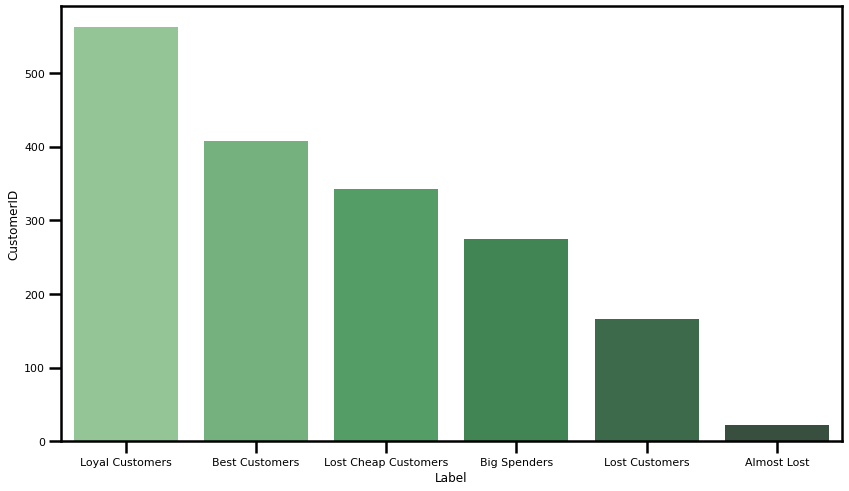

In [52]:
# visualising the labelled customer data
import seaborn as sns
sq1=segmented_rfm.groupby('Label')['CustomerID'].nunique().sort_values(ascending=False).reset_index()
plt.figure(figsize=(14,8))
sq1.drop([0],inplace=True)
sns.barplot(data=sq1, x="Label", y="CustomerID", palette = "Greens_d");

##Feature Engineering

In [53]:
# dropping customerID from RFM_Table_New
RFM_Table = RFM.drop('CustomerID', axis=1)

In [54]:
RFM_Table.head()

,Recency,Frequency,Monetary
0,325,1,77183.60
1,2,103,4196.01
2,0,4412,33053.19
3,3,199,4090.88
4,3,59,942.34


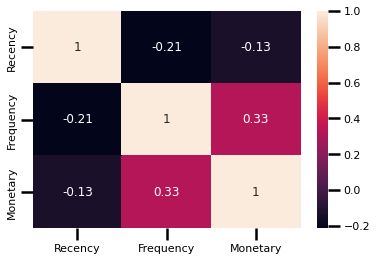

In [55]:
#Heatmap check
sns.heatmap(RFM_Table.corr(), annot=True);

Frequency and Monetary are positively correlated with each other,that implies with an increase in frequency increases monetary value.

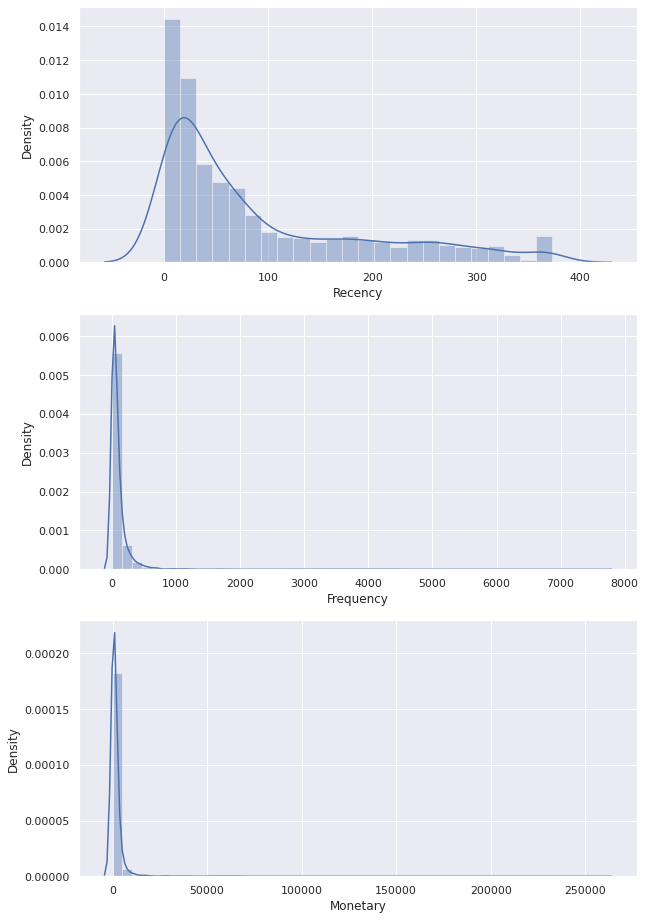

In [57]:
# Plotting the distribution plot before passing in the models

# Distribution plots
plt.figure(figsize=(10,16))
sns.set_theme(style="darkgrid")

# Plot recency 
plt.subplot(3, 1, 1)
sns.distplot(RFM_Table.Recency,axlabel='Recency')

# Plot frequency 
plt.subplot(3, 1, 2)
sns.distplot(RFM_Table.Frequency,axlabel='Frequency')

# Plot monetary value 
plt.subplot(3, 1, 3)
sns.distplot(RFM_Table.Monetary,axlabel='Monetary')

plt.show()

Lets Check For Outliers Too

NameError: ignored

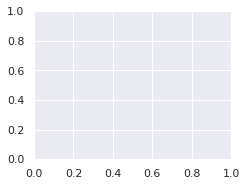

In [59]:
# checking for outliers
plt.figure(figsize=(12,6))

for i, feature in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(2,3,i+1)
    RFM_log[feature].plot(kind='box')

Observations:

From the above plot we can infer that

1. Recency,Frequency and monetary all are positively skewed.

2. Recency,Frequency and monetary possess outlier values.

We need to treat the outliers and make these distributions normalised before fitting the data into the model.

In [60]:
RFM_log = RFM_Table.copy()
RFM_log.head()

,Recency,Frequency,Monetary
0,325,1,77183.60
1,2,103,4196.01
2,0,4412,33053.19
3,3,199,4090.88
4,3,59,942.34


In [61]:
# log transformation
RFM_log = np.log(RFM_log+1)

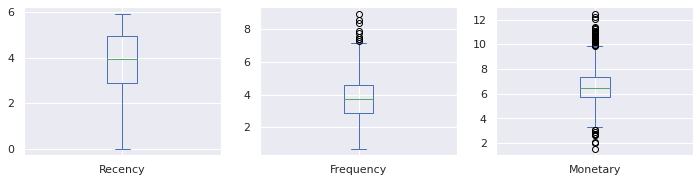

In [62]:
#  visualising distribution of RFM once again
plt.figure(figsize=(12,6))

for i, feature in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(2,3,i+1)
    RFM_log[feature].plot(kind='box')

Now we can see that the outliers has been removed to much extent.


* Now since the skewness is reduced,we'll standardise the data by centring and scaling. Note all the variables now have a mean of 0 and a standard deviation of 1.

In [63]:
# Developing preprocessing with StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(RFM_log)
RFM_scaled = scaler.transform(RFM_log)

In [64]:
RFM_scaled = pd.DataFrame(RFM_scaled, columns=RFM_Table.columns)
RFM_scaled.head()

,Recency,Frequency,Monetary
0,1.438428,-2.407557,3.788077
1,-1.953555,0.743030,1.447841
2,-2.748403,3.731493,3.106498
3,-1.745416,1.264449,1.427453
4,-1.745416,0.304442,0.248157


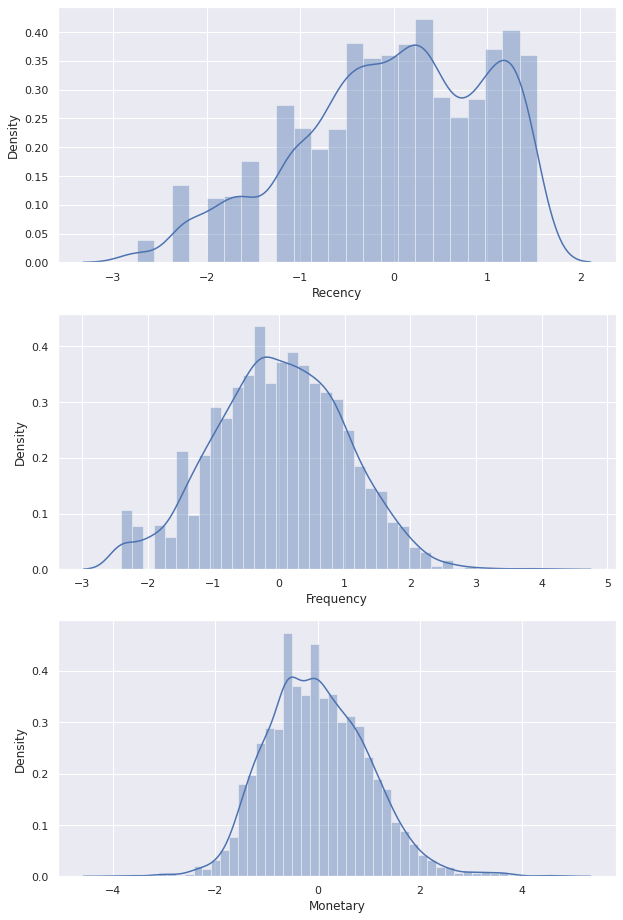

In [65]:
# Plotting the distribution plot before passing in the models

# Distribution plot
plt.figure(figsize=(10,16))
sns.set_theme(style="darkgrid")

# Plot recency 
plt.subplot(3, 1, 1); sns.distplot(RFM_scaled.Recency,axlabel='Recency')

# Plot frequency 
plt.subplot(3, 1, 2); sns.distplot(RFM_scaled.Frequency,axlabel='Frequency')

# Plot monetary value 
plt.subplot(3, 1, 3); sns.distplot(RFM_scaled.Monetary,axlabel='Monetary')

plt.show()

Hence our distributions are normalized

## Building the Model


In [66]:
# Create a pandas DataFrame
X = pd.DataFrame(data=RFM_scaled, index=RFM_log.index, columns=RFM_log.columns)
X


,Recency,Frequency,Monetary
0,1.438428,-2.407557,3.788077
1,-1.953555,0.743030,1.447841
2,-2.748403,3.731493,3.106498
3,-1.745416,1.264449,1.427453
4,-1.745416,0.304442,0.248157
...,...,...,...
3915,1.323192,-1.048249,-1.076036
3916,1.012720,-1.302173,-1.716813
3917,-1.243923,-0.915045,-1.087401
3918,-1.745416,2.288034,0.870602


* Hunting For Optimal Cluster Value

1. **Silhoutte Analysis**

Silhouette score is used to evaluate the quality of clusters created using clustering algorithms such as K-Means in terms of how well samples are clustered with other samples that are similar to each other. The Silhouette score is calculated for each sample of different clusters.

Silhouette score for number of cluster(s) 2: 0.3999126949399304
Silhouette score for number of cluster(s) 3: 0.3064940535686558
Silhouette score for number of cluster(s) 4: 0.3051587677125667
Silhouette score for number of cluster(s) 5: 0.27589083045249363
Silhouette score for number of cluster(s) 6: 0.2732796171003843
Silhouette score for number of cluster(s) 7: 0.2608426784729811
Silhouette score for number of cluster(s) 8: 0.2577422336407989
Silhouette score for number of cluster(s) 9: 0.25693486860256953


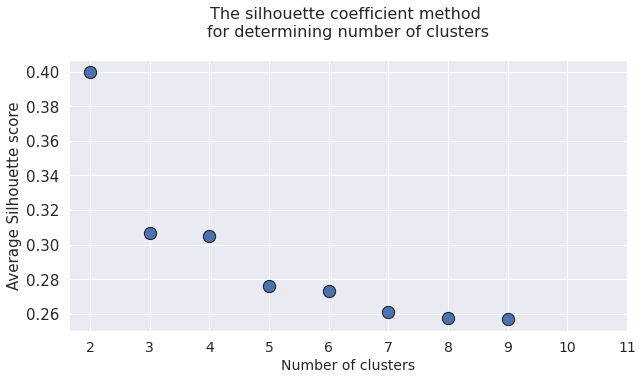

In [67]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
Silhouette_score = []
for i in range(2,10):
  kmean = KMeans(n_clusters=i, random_state=0,init='k-means++').fit(X)
  preds = kmean.predict(X)
  silhouette = silhouette_score(X,preds)
  Silhouette_score.append(silhouette)
  print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))

plt.figure(figsize=(10,5))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,10)],y=Silhouette_score,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Average Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

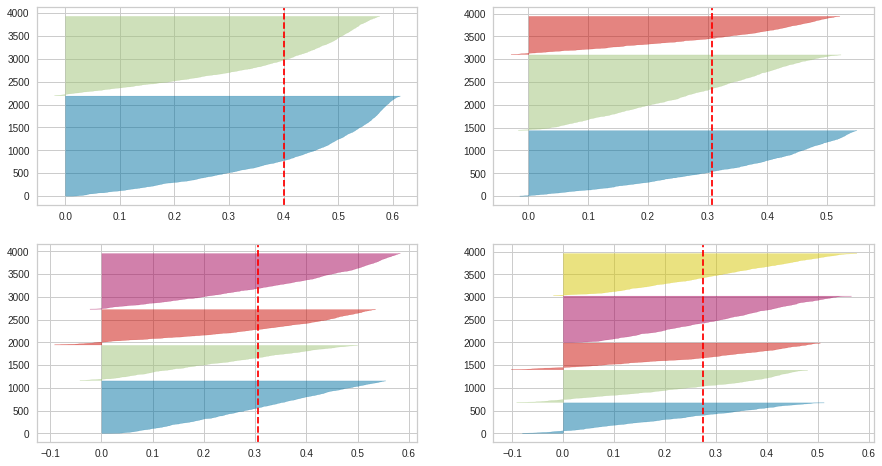

In [68]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2,3,4,5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)

2. Elbow Method

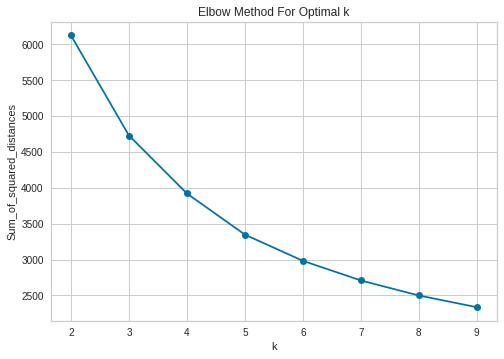

In [69]:
# elbow method for optimal k
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
#  'bx-'
# sns.set_style('whitegrid')
plt.plot(K, Sum_of_squared_distances,marker='o')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

3. Davies Bouldin Score

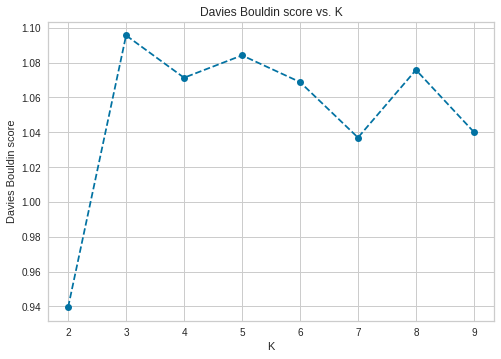

In [70]:
# Davies Bouldin score for K means
from sklearn.metrics import davies_bouldin_score
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

# Then fit the model to your data using the fit method
    model = kmeans.fit_predict(X)
    
    # Calculate Davies Bouldin score
    score = davies_bouldin_score(X, model)
    return score
    
scores = []
centers = list(range(2,10))
for center in centers:
    scores.append(get_kmeans_score(X, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K');

Now since all Silhouette Score,Elbow Method and Davies Bouldin score suggests optimal K=2 we'll go forward with 2 clusters

### **K-Means Clustering**

Text(0, 0.5, 'Money Spend')

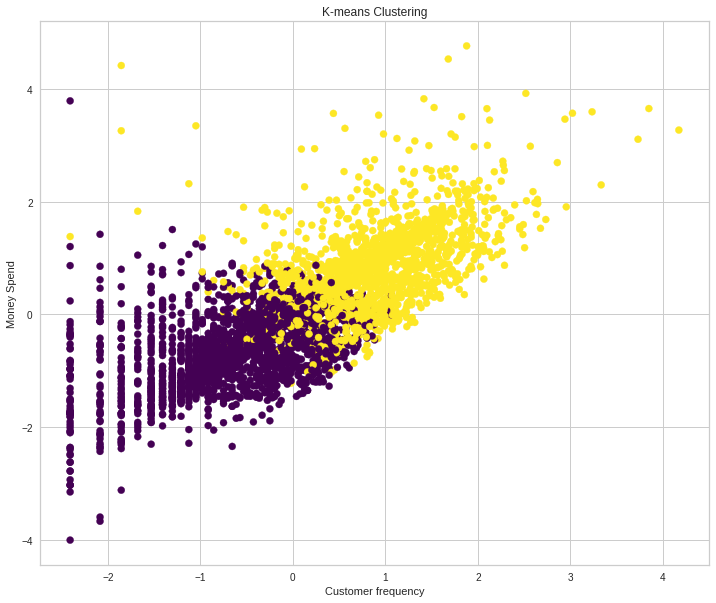

In [71]:
# Scatter plot for K-means clustering
X_val=X.values
plt.figure(figsize=(12,10))

labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X_val[:, 1], X_val[:, 2], c=labels, s=50, cmap='viridis')

plt.title('K-means Clustering')
plt.xlabel('Customer frequency')
plt.ylabel('Money Spend')

### **Hierarchical clustering**

There are mainly two types of hierarchical clustering:

* Agglomerative hierarchical clustering

* Divisive Hierarchical clustering

For Our Analysis We we'll go with Agglomerative hierarchical clustering

1. **Silhoutte Analysis**

In [72]:
# Fit the data to Agglomerative Clustering model
from sklearn.cluster import AgglomerativeClustering

Silhouette score for number of cluster(s) 2: 0.3498330262361491
Silhouette score for number of cluster(s) 3: 0.25747043294050875
Silhouette score for number of cluster(s) 4: 0.23864137000005292
Silhouette score for number of cluster(s) 5: 0.22582299793204233
Silhouette score for number of cluster(s) 6: 0.2250240642102831
Silhouette score for number of cluster(s) 7: 0.205283623773681
Silhouette score for number of cluster(s) 8: 0.20946538242138188
Silhouette score for number of cluster(s) 9: 0.20810506381917787


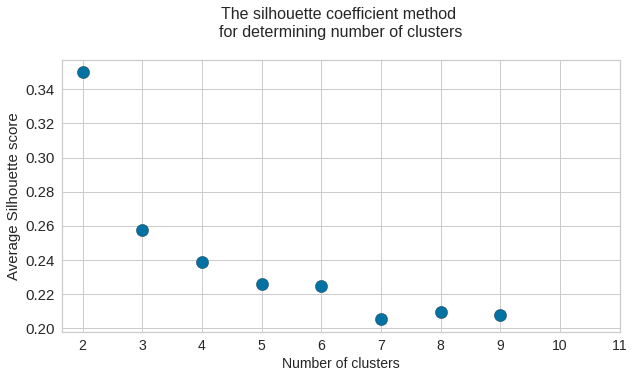

In [73]:
# Calculate the silhoutte score for 19 different cluster from 2-20 
hc_silhouette = []
for i in range(2,10):
    
    
    # Fit the data to Agglomerative Clustering model
    hc = AgglomerativeClustering(n_clusters = i, affinity = 'euclidean', linkage = 'ward')
    y_hc = hc.fit_predict(X_val)    
    
    # Count silhouettte score for each cluster
    silhouette = silhouette_score(X,y_hc)
    hc_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))

plt.figure(figsize=(10,5))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,10)],y=hc_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Average Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

2. **Davies-Bouldin Index**

In [74]:
from sklearn.metrics import davies_bouldin_score
def get_Hmeans_score(data, center):  
    #instantiate Hierarchical Clustering
    
    hmeans = AgglomerativeClustering(n_clusters=center, affinity= 'euclidean', linkage='ward')
    
    #fit the model to the data using the fit method
    model = hmeans.fit_predict(data)

    #Calculate Davies Bouldin score
    score = davies_bouldin_score(data, model)
    return score

Text(0.5, 1.0, 'Davies Bouldin score vs. K')

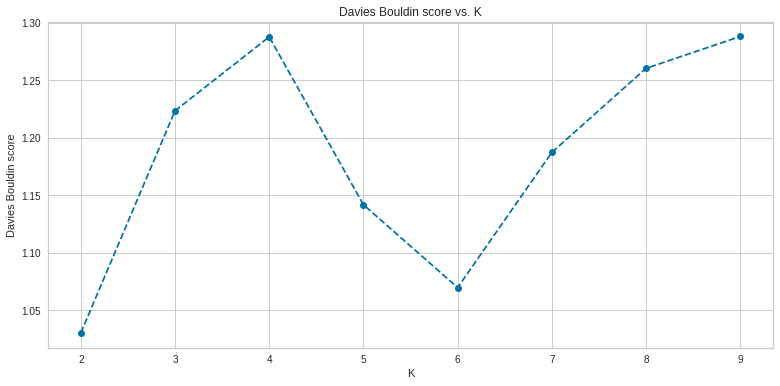

In [75]:
# Number of Clusters in the data
centers = list(range(2, 10)) 
avg_scores = []
for center in centers:
 avg_scores.append(get_Hmeans_score(X,center))
plt.figure(figsize=(13,6));
 
plt.plot(centers, avg_scores, linestyle= '--' , marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Davies Bouldin score')
plt.title('Davies Bouldin score vs. K')

3. **Structural Analysis Using Dendrogram**

A dendrogram is a diagram that shows the hierarchical relationship between objects. It is most commonly created as an output from hierarchical clustering.

Text(0, 0.5, 'Euclidean Distances')

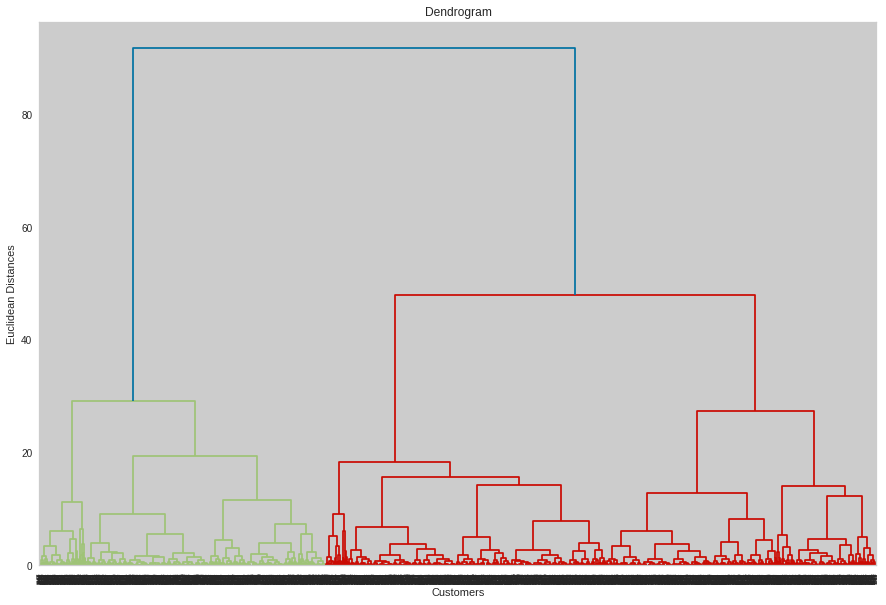

In [76]:
from pylab import rcParams
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plot
import seaborn as sns

# Define train dataset by taking the frequency and monetary column
X = X.iloc[:, 1:]

# Using the dendogram to find the optimal number of clusters
rcParams['figure.figsize'] = 15, 10
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')


**Dendrogram shows that optimal number of clusters can derived is 2**

So put Line in above dendrogram such way that it cut into 2 cluster

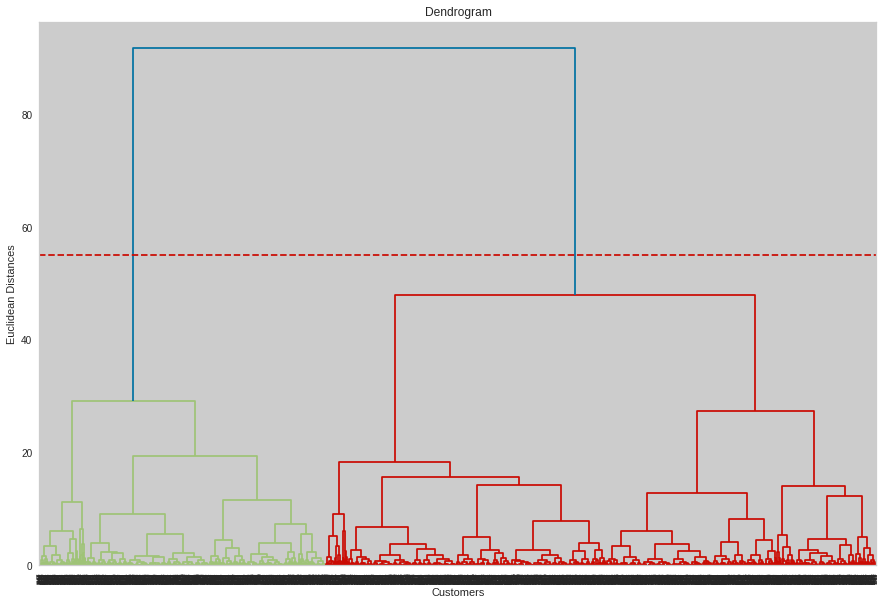

In [77]:
# Plot the dendrogram and put the horizontal line on y at 45
import matplotlib.pyplot as plot
import seaborn as sns

rcParams['figure.figsize'] = 15, 10
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.axhline(y=55, color='r', linestyle='--')

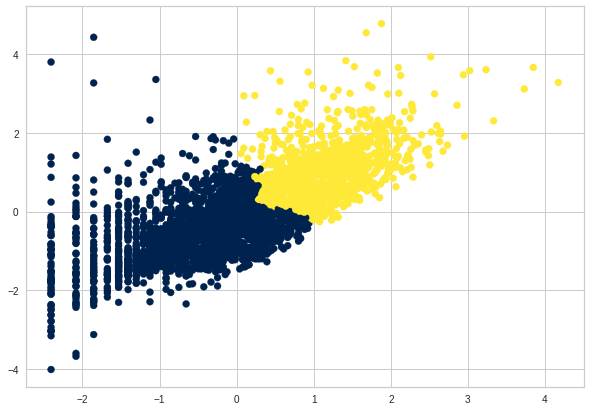

In [78]:
# Scatter plot for Agglomerative Clustering
labels = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward').fit_predict(X)
plt.figure(figsize=(10, 7))  
plt.scatter(X['Frequency'], X['Monetary'],c=labels,cmap='cividis')

### **Summary:**
RFM analysis can segment customers into homogenous group quickly with set of minimum variables. Scoring system can be defined and ranged differently. We get a better result for clustering steps by applying scoring rather than using the raw calculated RFM values. Therefore, segmenting should be done by RFM scoring and further analysis on the spending behavior should be done on the raw values for the targeted cluster to expose more insight and characteristics. RFM analysis solely depends on purchasing behavior and histories, analysis can be further improved by exploring weighted composite scoring or including customer demographic information and product information.

### **Conclusion:**

RFM analysis can help in answering many questions with respect to their customers and this can help companies to make marketing strategies for their customers, retaining their slipping customers and providing recommendations to their customer based on their interest. We used the K-means and Heirarchcal algorithm to segment our customer in various clusters having similar similarity.